In [116]:
youtube_data = pd.read_pickle("youtube_features.pkl")

# Predicting Youtube View Counts

In this project our goal was to analyze what features of youtube videos contribute most to its view count. It is interesting to see, given a new video, how many views we could predict that video to have. Knowing certain features influence view count could help a youtube influencer better promote their video.

## Data Collection

We wanted to gather a large unbaised random sample of about 100,000 youtube videos with a good view count distribution. This task ended up being more challenging than we anticipated. 


### Attempt 1
Our first attempt was to generate a random video id. This is a 11 character string of numbers and letters. However such an id often does not correspond to an existing video. Since we wanted to do text analysis, we filtered to only have English videos which further limited our results. So in querying the Youtube API we quickly hit our daily quota (of 1 million units) without getting even a few 100 videos. 

### Attempt 2
Since generating an entire video id rarely hit a valid video we instead tried only generating a partial id and searching for videos containing that id. Since the API doesn't support search by partial id we instead searched with that partial id as the keyword. We then searched through the resulting videos (50 max) to find if one of them had an id containing partial id and was in English. The issue was that since we only could use one video out of the 50 results and we had to make a second query to get all the corresponding video details, this once again quickly maxed our query limit. 

### Attempt 3
This time we randomly chose a word from the English dictionary and used that as the query term. The problem with this was that since Youtube sorts results by relevance (which is usually view count), this biased our results to have really high view counts. The only ways to change this sort was by date published or rating which would still lead to in biased results. We considered seaching with more than one English word to make it less common to hit a match. This still did not completely resolve the aforementioned issues though.

### Final Attempt
Ultimately we found a tensorflow dataset (https://research.google.com/youtube8m/download.html) of 8 million random video ids. From this we randomly selected 10% of the ids and made a second query to the Youtube API to obtain the video details. This involved filtering if the result was not English or no longer corresponded to an actual video (i.e. was removed since publication of dataset etc). Most of these ids corresponded to existing English videos so we could complete the scraping process within the limits of the API quota. We ended with approximatley 90,000 videos.  

In [ ]:
from googleapiclient.discovery import build
from googletrans import Translator
import random
import string
import json
import csv
import pandas as pd

global videoIdLen
videoIdLen = 3
numVideos = 3

#from youtube API documentation
def remove_empty_kwargs(**kwargs):
  good_kwargs = {}
  if kwargs is not None:
    for key, value in kwargs.items():
      if value:
        good_kwargs[key] = value
  return good_kwargs

#from youtube API documentation
def videos_list_by_id(client, **kwargs):
  kwargs = remove_empty_kwargs(**kwargs)

  response = client.videos().list(
    **kwargs
  ).execute()
  return response

#from youtube API documentation
def get_authenticated_service():
    api_key = open('api_key.txt', 'r').read()
    return build('youtube', 'v3', developerKey = api_key)


def checkField(vid, fieldType, first, second):
    if (second in vid[first]):
        return vid[first][second]
    else:
        if (fieldType == "str"):
            return ""
        elif (fieldType == "int"):
            return 0
        else:
            return []

client = get_authenticated_service()
f = open("rand_videos.txt","a")
translator = Translator()
csv_file = open('video_data.csv', 'w', newline = "", encoding='utf-8')
fieldnames = ['id', 'title', 'description', 'channelTitle', 'commentCount', 'viewCount', 'favoriteCount', 'dislikeCount', 'likeCount', 'tags', 'topics']
writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
writer.writeheader()

f_ids = open("videoIdsAndLabels.txt", "r")
vocab = pd.read_csv("vocabulary.csv")

for line in f_ids:
    parts = line.split()
    vidId = parts[0]
    labels = parts[1:]
    
    video_response = videos_list_by_id(client,
        id = vidId,
        part = 'snippet, statistics')
    newVideo = {}
    try:  
        if (len(video_response['items']) == 0):
            continue
        vid = video_response['items'][0]
        title = vid['snippet']['title']
        lang = translator.detect(title)
        if lang.lang == 'en' and lang.confidence > 0.50:
            topics = []
            for label in labels:
                label_fix = label.replace('[','').replace(']','').replace(',','')
                topic = vocab['Name'][int(label_fix)]
                topics.append(topic)
            newVideo['topics'] = topics
            newVideo['id'] = vidId
            newVideo['title'] = title 
            newVideo['description'] = checkField(vid, "str", "snippet", "description")
            newVideo['channelTitle'] = checkField(vid, "str", "snippet", "channelTitle")
            newVideo['commentCount'] = checkField(vid, "int", "statistics", "commentCount")
            newVideo['viewCount'] = checkField(vid, "int", "statistics", "viewCount")
            newVideo['favoriteCount'] = checkField(vid, "int", "statistics", "favoriteCount")
            newVideo['dislikeCount'] = checkField(vid, "int", "statistics", "dislikeCount")
            newVideo['likeCount'] = checkField(vid, "int", "statistics", "likeCount")
            newVideo['tags'] = checkField(vid, "list", "snippet", "tags")
            writer.writerow(newVideo)
            f.write(json.dumps(vid))
            f.write('\n')
    except Exception as e:
        print("in except")
        print(e)
        print(newVideo)

f.close()
f_ids.close()
csv_file.close()

## Data 

The data we collected had the following features:
    1. topics (list of strings)
    2. id (string)
    3. title (string) 
    4. description (string)
    4. channel title (string)
    5. comment count (int)
    6. view count (int)
    7. favorite count (int)
    8. dislike count (int)
    9. like count (int)
    10. tags (list of strings)

## Data Visualization

Next we wanted to see which features were correlated with view count. To do this we used plotnine which implements gglot in Python.

In [96]:
import warnings
warnings.filterwarnings('ignore')

In [1]:
from plotnine import *
import pandas as pd 
import numpy as np

youtube_data = pd.read_csv("video_data_final.csv", encoding = "ISO-8859-1")

We started by visualizing the distribution of view counts. This boxplot shows the distribution is heavily right skewed. 

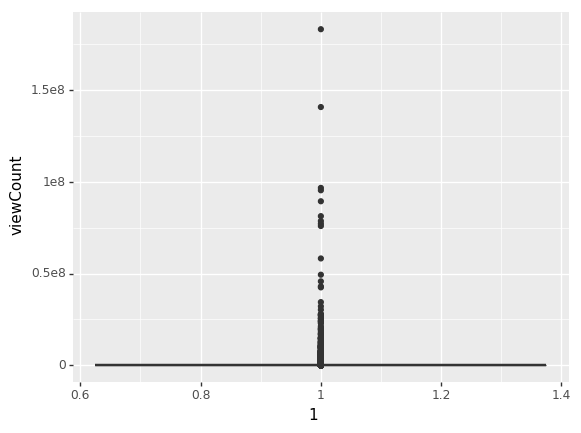

<ggplot: (291058317)>

In [91]:
ggplot(youtube_data, aes(y = "viewCount", x = '1')) + \
    geom_boxplot(alpha = 0.5)

To adjust for the skewedness we tried a log transform.

/Users/rupalnahar/anaconda3/lib/python3.6/site-packages/plotnine/scales/scale.py:516: RuntimeWarning: divide by zero encountered in log10
  return self.trans.transform(x)
/Users/rupalnahar/anaconda3/lib/python3.6/site-packages/plotnine/layer.py:363: UserWarning: stat_boxplot : Removed 17 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


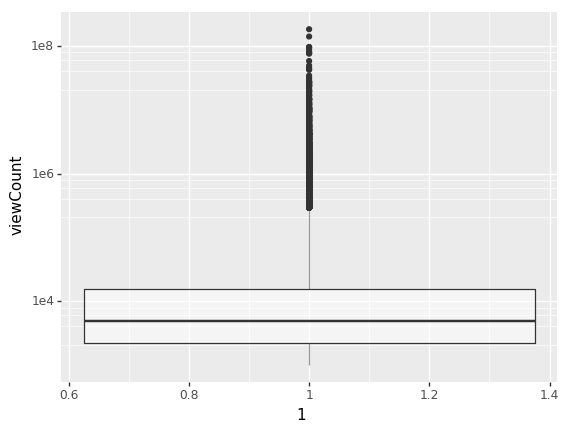

<ggplot: (-9223372036520801020)>

In [89]:
ggplot(youtube_data, aes(y = "viewCount", x = '1')) + \
    geom_boxplot(alpha = 0.5) + \
    scale_y_log10()

Although this looked better, it shows a normally distributed group of points followed by a group of very high outliers. 

In [5]:
youtube_data["viewCount"].describe()

count    9.219100e+04
mean     6.946795e+04
std      1.248694e+06
min      0.000000e+00
25%      2.240000e+03
50%      4.942000e+03
75%      1.573100e+04
max      1.832004e+08
Name: viewCount, dtype: float64

Consequenly we decided to split our data into 2 groups: outlier vs non-outlier. We used the statistics above to determine to split at 1.5*(interquartile range) + 75th percentile. 

In [93]:
outlier_start = 1.5*(15731.00 - 2240.000) + 15731.00 #1.5(IQR) + 75th quartile
youtube_data['outlier'] = np.where(youtube_data['viewCount']>=outlier_start, 'outlier', 'notOutlier')

In the following graph we see now the nonoutlier data looks relatively normally distributed. The outlier data is still skewed right.

/Users/rupalnahar/anaconda3/lib/python3.6/site-packages/plotnine/scales/scale.py:516: RuntimeWarning: divide by zero encountered in log10
  return self.trans.transform(x)
/Users/rupalnahar/anaconda3/lib/python3.6/site-packages/plotnine/layer.py:363: UserWarning: stat_boxplot : Removed 17 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


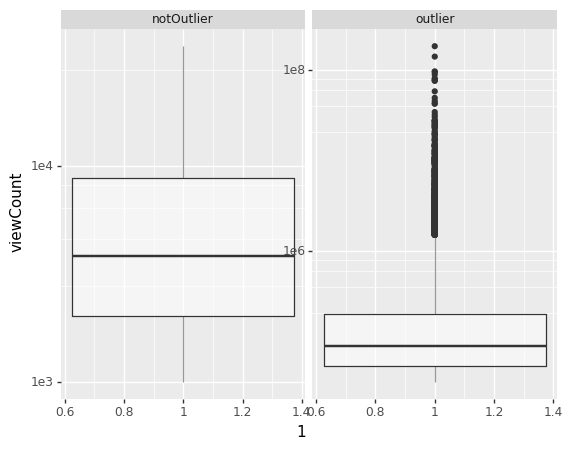

<ggplot: (-9223372036575018622)>

In [94]:
ggplot(youtube_data, aes(y = "viewCount", x = '1')) + \
    geom_boxplot(alpha = 0.5) + \
    scale_y_log10() + \
    facet_wrap("outlier", scales="free")

We now go into visualizing the features, starting with like, dislike and comment counts. For all 3 of these graphs it was better to do a log transform on the x axis as well. 

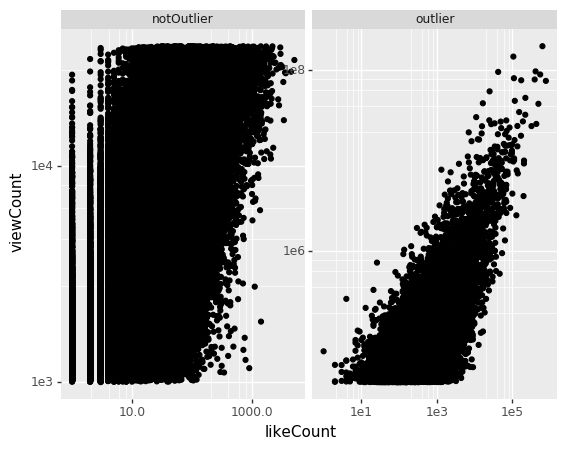

<ggplot: (420003062)>

In [106]:
ggplot(youtube_data, aes(x = "likeCount", y = "viewCount",)) + \
    geom_point() + \
    scale_x_log10() + \
    scale_y_log10() + facet_wrap("outlier", scales="free")

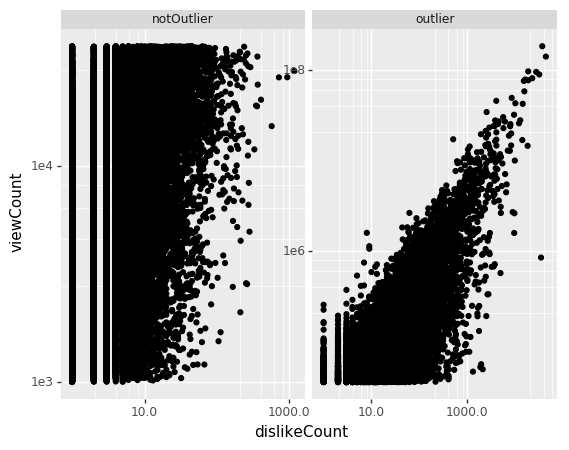

<ggplot: (404122828)>

In [105]:
ggplot(youtube_data, aes(x = "dislikeCount", y = "viewCount")) + \
    geom_point() + \
    scale_x_log10() + \
    scale_y_log10()  + facet_wrap("outlier", scales="free")

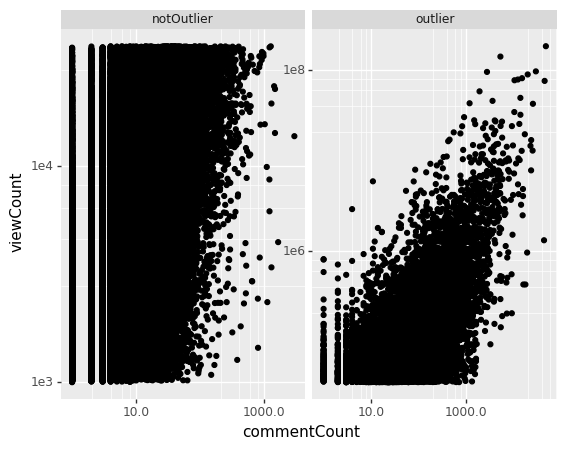

<ggplot: (398109125)>

In [104]:
ggplot(youtube_data, aes(x = "commentCount", y = "viewCount")) + \
    geom_point() + \
    scale_x_log10() + \
    scale_y_log10()  + facet_wrap("outlier", scales="free")

We note there is a slight positive corrleation in the non-outliers and a greater positive correlation in the outliers.

### Text Analysis on Title Feature

We explored several different ways of using the title. We started with a basic approach of just looking at the length of the title.

#### Method 0: Length of Title

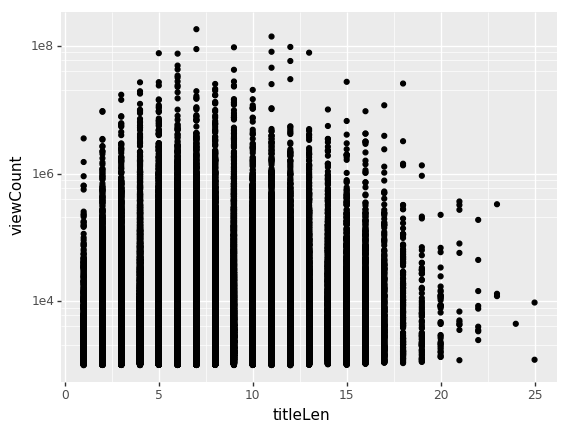

<ggplot: (-9223372036307068812)>

In [159]:
youtube_data['titleLen'] = youtube_data['titleWords'].apply(lambda x: len(x))

ggplot(youtube_data, aes(x = 'titleLen', y = 'viewCount')) + \
scale_y_log10() + geom_point() 

#### Method 1: Tfidf

Next we tried to convert the title into tfidf vectors.

In [109]:
from sklearn.feature_extraction.text import TfidfVectorizer

def toTfidf(text):
    vectorizer = TfidfVectorizer(stop_words = "english")
    # tokenize and build vocab
    return (vectorizer.fit_transform(text))

allTitles = list(youtube_data['title'])
tfidf = toTfidf(allTitles)

def getFeatures(tfidf, tfidf_type):
    result = []
    for i in range(tfidf.shape[0]):
        vector = tfidf[i]
        if (tfidf_type == 'min'):
            result.append(np.min(vector))
        elif (tfidf_type == 'max'):
            result.append(np.max(vector))
        else:
            #average
            result.append(np.mean(vector))
    return pd.Series(result)

We considered 2 ways of doing tdifd: mean and min. The initial goal was to use the min method because tfidf assigns the more frequent words with lower tfidf scores. We expect the more frequent words to be the clickbait words which might influence the view count the most. However, since tfidf features is a sparse matrix the min was mostly 0. Thus we resorted to trying mean.  

In [110]:
youtube_data['mean_title'] = getFeatures(tfidf, 'mean')

KeyboardInterrupt: 

In [112]:
youtube_data['min_title'] = getFeatures(tfidf, 'min')
print(youtube_data['min_title'].unique())

[0.]


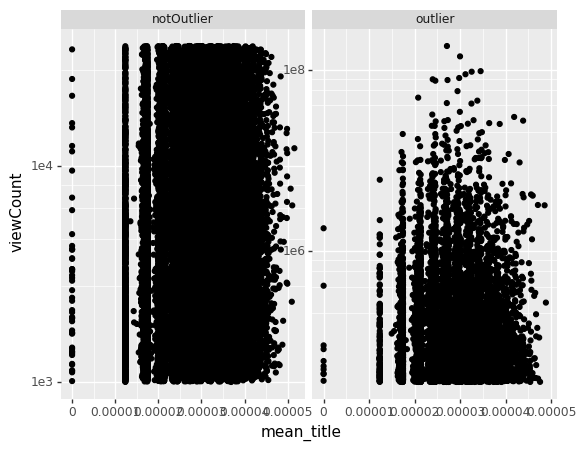

<ggplot: (-9223372036388116641)>

In [114]:
ggplot(youtube_data, aes(x = "mean_title", y = "viewCount")) + \
    geom_point() + \
    scale_y_log10() + \
    facet_wrap("outlier", scales="free")

We do not see any correlation between mean title and view count. Thus we will not use this as a feature in our ML model. 

####  Method 2: Part of Speech Tagging

Next, we tagged each of the words in the title with its corresponding part of speech. We then converted this to a frequency vector for each part of speech tag. 

In [156]:
import nltk

youtube_data['pos_tags'] = youtube_data['titleWords'].apply(lambda t: nltk.pos_tag(t))

In [160]:
from collections import Counter

youtube_data['pos_freq'] = youtube_data['pos_tags'].apply(lambda l: Counter([tag for (word, tag) in l]))

In [154]:
df1 = youtube_data['pos_freq'].apply(lambda x: x['NNP'])
df1.loc[df1 == 83]


id                                                       7c8G2ZhJq5U
title              MAYWEATHER VS BERTO FACE OFF STAREDOWN 8/6/15!...
description        - Mayweather vs Berto 9/12/15 Showtime PPV *UN...
channelTitle                                TstreeT Controversy LIVE
commentCount                                                      19
viewCount                                                      11633
favoriteCount                                                      0
dislikeCount                                                      21
likeCount                                                         44
tags               ['todays', 'news', 'boxing', 'review', 'previe...
topics                                                    ['Boxing']
outlier                                                   notOutlier
mean_title                                               3.33935e-05
max_title                                                   0.615944
min_title                         

In [176]:
youtube_data['title_CC'] = youtube_data['pos_freq'].apply(lambda C: C['CC'])
youtube_data['title_CD'] = youtube_data['pos_freq'].apply(lambda C: C['CD'])
youtube_data['title_DT'] = youtube_data['pos_freq'].apply(lambda C: C['DT'])
youtube_data['title_EX'] = youtube_data['pos_freq'].apply(lambda C: C['EX'])
youtube_data['title_IN'] = youtube_data['pos_freq'].apply(lambda C: C['IN'])
youtube_data['title_JJ'] = youtube_data['pos_freq'].apply(lambda C: C['JJ'])
youtube_data['title_JJR'] = youtube_data['pos_freq'].apply(lambda C: C['JJR'])
youtube_data['title_JJS'] = youtube_data['pos_freq'].apply(lambda C: C['JJS'])
youtube_data['title_LS'] = youtube_data['pos_freq'].apply(lambda C: C['LS'])
youtube_data['title_MD'] = youtube_data['pos_freq'].apply(lambda C: C['MD'])
youtube_data['title_NN'] = youtube_data['pos_freq'].apply(lambda C: C['NN'])
youtube_data['title_NNP'] = youtube_data['pos_freq'].apply(lambda C: C['NNP'])
youtube_data['title_NNS'] = youtube_data['pos_freq'].apply(lambda C: C['NNS'])
youtube_data['title_NNPS'] = youtube_data['pos_freq'].apply(lambda C: C['NNPS'])
youtube_data['title_PDT'] = youtube_data['pos_freq'].apply(lambda C: C['PDT'])
youtube_data['title_POS'] = youtube_data['pos_freq'].apply(lambda C: C['POS'])
youtube_data['title_PRP'] = youtube_data['pos_freq'].apply(lambda C: C['PRP'])
youtube_data['title_PRP$'] = youtube_data['pos_freq'].apply(lambda C: C['PRP$'])
youtube_data['title_RB'] = youtube_data['pos_freq'].apply(lambda C: C['RB'])
youtube_data['title_RBR'] = youtube_data['pos_freq'].apply(lambda C: C['RBR'])
youtube_data['title_RBS'] = youtube_data['pos_freq'].apply(lambda C: C['RBS'])
youtube_data['title_RP'] = youtube_data['pos_freq'].apply(lambda C: C['RP'])
youtube_data['title_TO'] = youtube_data['pos_freq'].apply(lambda C: C['TO'])
youtube_data['title_UH'] = youtube_data['pos_freq'].apply(lambda C: C['UH'])
youtube_data['title_VB'] = youtube_data['pos_freq'].apply(lambda C: C['VB'])
youtube_data['title_VBD'] = youtube_data['pos_freq'].apply(lambda C: C['VBD'])
youtube_data['title_VBG'] = youtube_data['pos_freq'].apply(lambda C: C['VBG'])
youtube_data['title_VBN'] = youtube_data['pos_freq'].apply(lambda C: C['VBN'])
youtube_data['title_VBP'] = youtube_data['pos_freq'].apply(lambda C: C['VBP'])
youtube_data['title_VBZ'] = youtube_data['pos_freq'].apply(lambda C: C['VBZ'])
youtube_data['title_WDT'] = youtube_data['pos_freq'].apply(lambda C: C['WDT'])
youtube_data['title_WP'] = youtube_data['pos_freq'].apply(lambda C: C['WP'])
youtube_data['title_WRB'] = youtube_data['pos_freq'].apply(lambda C: C['WRB'])

We took out the tags that had max count of 0 since these would not give us any information. We also removed the tags which had no correlation with view count. The remaining tags were: 

In [13]:
top_topics = ['Game', 'Vehicle', 'Video game', 'Concert', 'Car', 'Animation', 'Musician', 'Dance', 'Music video', 'Motorsport']

def numberCommon(topicsStr, top_topics):
    num = 0
    for word in top_topics:
        if word in topicsStr:
            num += 1
    return num
    

In [14]:
youtube_data['topics_features'] = youtube_data['topics'].apply(lambda topics : numberCommon(topics, top_topics))
youtube_data['game'] = youtube_data['topics'].apply(lambda topics : 1 if 'Game' in topics else 0)
youtube_data['vehicle'] = youtube_data['topics'].apply(lambda topics : 1 if 'Vehicle' in topics else 0)
youtube_data['video_game'] = youtube_data['topics'].apply(lambda topics : 1 if 'Video game' in topics else 0)
youtube_data['concert'] = youtube_data['topics'].apply(lambda topics : 1 if 'Concert' in topics else 0)
youtube_data['car'] = youtube_data['topics'].apply(lambda topics : 1 if 'Car' in topics else 0)

In [ ]:
ggplot(youtube_data, aes(y = "viewCount", x = 'factor(topics_features)')) + \
    geom_boxplot(alpha = 0.5) + \
    scale_y_log10()

In [ ]:
ggplot(youtube_data, aes(y = "viewCount", x = 'factor(game)')) + \
    geom_boxplot(alpha = 0.5) + \
    scale_y_log10()

In [ ]:
ggplot(youtube_data, aes(y = "viewCount", x = 'factor(vehicle)')) + \
    geom_boxplot(alpha = 0.5) + \
    scale_y_log10()

In [ ]:
ggplot(youtube_data, aes(y = "viewCount", x = 'factor(video_game)')) + \
    geom_boxplot(alpha = 0.5) + \
    scale_y_log10()

In [ ]:
ggplot(youtube_data, aes(y = "viewCount", x = 'factor(concert)')) + \
    geom_boxplot(alpha = 0.5) + \
    scale_y_log10()

In [ ]:
ggplot(youtube_data, aes(y = "viewCount", x = 'factor(car)')) + \
    geom_boxplot(alpha = 0.5) + \
    scale_y_log10()

In [16]:
print(youtube_data['pos_tags'])

0        [(L, NNP), (i, NN), (e, NN), (b, NN), (h, NN),...
1        [(R, NN), (i, NN), (t, VBP), (a, DT), ( , NN),...
2        [(S, NNP), (y, PRP), (l, VBP), (v, FW), (a, DT...
3        [(a, DT), (f, JJ), (t, NN), (e, NN), (r, NN), ...
4        [(S, NNP), (e, NN), (r, NN), (e, NN), (n, IN),...
5        [(E, NNP), (l, NN), (l, NN), (e, NN), (n, JJ),...
6        [(A, DT), (r, NN), (k, NN), (h, VBD), (a, DT),...
7        [(D, NNP), (r, VBZ), (a, DT), (w, NN), (i, NN)...
8        [(P, NNP), (H, NNP), (I, PRP), (L, NNP), ( , N...
9        [(S, NNP), (t, VBZ), (a, DT), (r, NN), ( , NN)...
10       [(C, NNP), (H, NNP), (A, NNP), (I, PRP), (R, N...
11       [(N, NNP), (e, NN), (e, NN), (d, NN), ( , NNP)...
12       [(M, NNP), (y, PRP), ( , NNP), (T, NNP), (a, D...
13       [(i, NN), (o, VBP), (n, NN), (i, NN), (k, VBP)...
14       [(S, NNP), (H, NNP), (I, PRP), (N, NNP), (e, V...
15       [(W, NNP), (H, NNP), (Y, NNP), ( , NNP), (I, P...
16       [(W, IN), (a, DT), (i, NN), (a, DT), (l, NN), .

In [ ]:
posCols = [col for col in youtube_data.columns if 'title_' in col]
#allOutliers = youtube_data[youtube_data["viewCount"] >= outlier_start]
for colName in posCols:
    if (abs(nonOutliers['viewCount'].corr(nonOutliers[colName])) > 0.1):
        print("YAYYYYYYYYYYYY!")
    print(nonOutliers['viewCount'].corr(nonOutliers[colName]), youtube_data['viewCount'].corr(youtube_data[colName]))

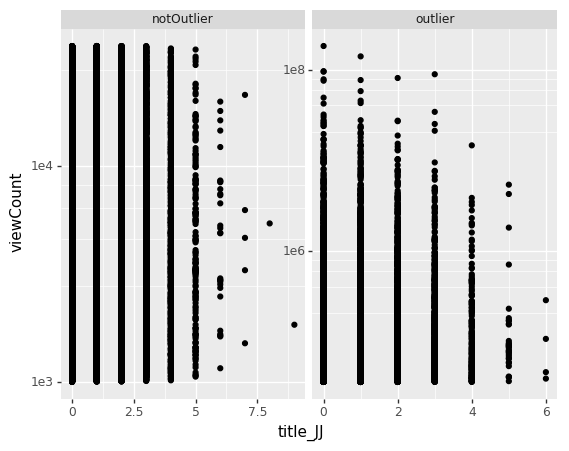

<ggplot: (415120630)>

In [169]:
#adjective
ggplot(youtube_data, aes(x = "title_JJ", y = "viewCount")) + \
    geom_point() + \
    scale_y_log10() + \
    facet_wrap("outlier", scales="free")

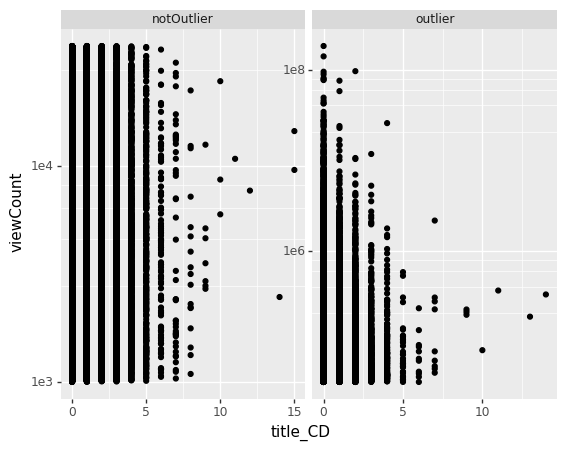

<ggplot: (-9223372036534732193)>

In [163]:
#Cardinal Digit
ggplot(youtube_data, aes(x = "title_CD", y = "viewCount")) + \
    geom_point()  + \
    scale_y_log10() + \
    facet_wrap("outlier", scales="free")

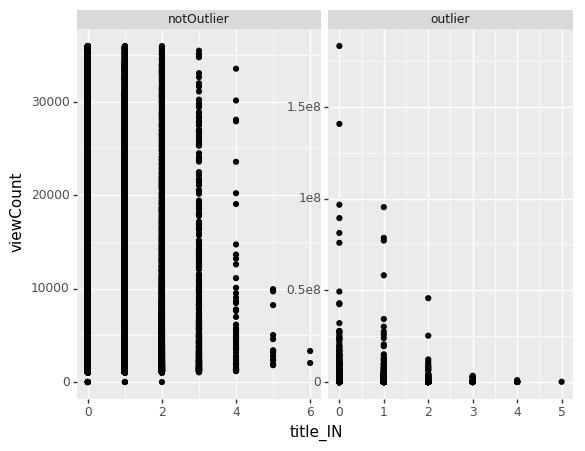

<ggplot: (-9223372036457518504)>

In [120]:
#Preposition or Subordinating Conjunction
ggplot(youtube_data, aes(x = "title_IN", y = "viewCount")) + \
    geom_point() + \
    facet_wrap("outlier", scales="free")

In [26]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

def getSentimentScore(text, sentimentType):
    #sentimentType: compound, neg, neu, pos
    return (analyzer.polarity_scores(text)[sentimentType])

In [27]:
youtube_data['description'] = youtube_data['description'].fillna('')

In [28]:
youtube_data['titlePos'] = youtube_data['title'].apply(lambda text : getSentimentScore(text, 'pos'))
youtube_data['titleNeg'] = youtube_data['title'].apply(lambda text : getSentimentScore(text, 'neg'))
youtube_data['titleNeu'] = youtube_data['title'].apply(lambda text : getSentimentScore(text, 'neu'))
youtube_data['titleCompound'] = youtube_data['title'].apply(lambda text : getSentimentScore(text, 'compound'))

In [29]:
youtube_data['descriptionPos'] = youtube_data['description'].apply(lambda text : getSentimentScore(text, 'pos'))
youtube_data['descriptionNeg'] = youtube_data['description'].apply(lambda text : getSentimentScore(text, 'neg'))
youtube_data['descriptionNeu'] = youtube_data['description'].apply(lambda text : getSentimentScore(text, 'neu'))
youtube_data['descriptionCompound'] = youtube_data['description'].apply(lambda text : getSentimentScore(text, 'compound'))

In [ ]:
ggplot(youtube_data, aes(x = "titlePos", y = "viewCount")) + \
    geom_point() + \
    scale_y_log10() + \
    scale_x_log10() + \
    facet_wrap("outlier", scales="free")

In [ ]:
ggplot(youtube_data, aes(x = "titleNeg", y = "viewCount")) + \
    geom_point() + \
    scale_y_log10() + \
    scale_x_log10() + \
    facet_wrap("outlier", scales="free")

In [ ]:
ggplot(youtube_data, aes(x = "titleNeu", y = "viewCount")) + \
    geom_point() + \
    scale_y_log10() + \
    scale_x_log10() + \
    facet_wrap("outlier", scales="free")

#youtube_data['titleNeu'].corr(youtube_data['viewCount'])
#nonOutliers['titleNeu'].corr(nonOutliers['viewCount'])

In [ ]:
ggplot(youtube_data, aes(x = "titleCompound", y = "viewCount")) + \
    geom_point() + \
    scale_y_log10() + \
    scale_x_log10() + \
    facet_wrap("outlier", scales="free")

In [ ]:
ggplot(youtube_data, aes(x = "descriptionPos", y = "viewCount")) + \
    geom_point()

In [ ]:
ggplot(youtube_data, aes(x = "descriptionNeg", y = "viewCount")) + \
    geom_point()

In [ ]:
ggplot(youtube_data, aes(x = "descriptionNeu", y = "viewCount")) + \
    geom_point()

In [ ]:
ggplot(youtube_data, aes(x = "descriptionCompound", y = "viewCount")) + \
    geom_point()

In [30]:
import re
import string
def process(text, lemmatizer=nltk.stem.wordnet.WordNetLemmatizer()):
    """ Normalizes case and handles punctuation
    Inputs:
        text: str: raw text
        lemmatizer: an instance of a class implementing the lemmatize() method
                    (the default argument is of type nltk.stem.wordnet.WordNetLemmatizer)
    Outputs:
        list(str): tokenized text
    """
    text = text.lower()
    text = re.sub('\'s', '', text)
    text = re.sub('\'', '', text)
    translator = str.maketrans(string.punctuation, ' '*len(string.punctuation))
    out = text.translate(translator)
    arr = nltk.word_tokenize(out)
    ans = []
    for word in arr:
        try:
            w = lemmatizer.lemmatize(word)
            ans.append(w)
        except:
            continue
    return ans

#youtube_data['title'].str.lower().str.split()
#youtube_data['title'].head()

In [31]:
youtube_data['titleWords'] = youtube_data['title'].apply(lambda x: process(x))

In [32]:
words = youtube_data['titleWords'].sum()

In [33]:
import collections
counter = collections.Counter(words)
print(counter.most_common(100))
len(words)

[('the', 13461), ('of', 7031), ('to', 6098), ('2', 5776), ('and', 5738), ('in', 5639), ('a', 5187), ('1', 4293), ('v', 3999), ('on', 3769), ('3', 3542), ('video', 3372), ('how', 3303), ('for', 3171), ('with', 3104), ('by', 3038), ('part', 3002), ('live', 2666), ('at', 2644), ('4', 2416), ('hd', 2360), ('5', 2086), ('new', 2062), ('review', 2045), ('my', 2042), ('music', 1878), ('2012', 1872), ('2013', 1856), ('cover', 1724), ('2011', 1684), ('i', 1657), ('dance', 1642), ('you', 1596), ('2014', 1548), ('2010', 1404), ('game', 1403), ('trailer', 1383), ('official', 1377), ('world', 1366), ('10', 1335), ('day', 1277), ('guitar', 1236), ('from', 1231), ('6', 1172), ('black', 1141), ('me', 1093), ('it', 1091), ('gameplay', 1079), ('your', 1069), ('is', 1063), ('tutorial', 1062), ('dj', 1060), ('2009', 1047), ('up', 1022), ('play', 1008), ('one', 1001), ('all', 998), ('love', 980), ('2015', 980), ('7', 977), ('best', 970), ('show', 962), ('12', 939), ('8', 916), ('11', 913), ('minecraft', 90

662575

In [34]:
stopwords=nltk.corpus.stopwords.words('english')
realWords = collections.Counter()
for word in counter:
    if word not in stopwords:
        realWords[word] += counter[word]
len(realWords)
print(realWords.most_common(100))

[('2', 5776), ('1', 4293), ('v', 3999), ('3', 3542), ('video', 3372), ('part', 3002), ('live', 2666), ('4', 2416), ('hd', 2360), ('5', 2086), ('new', 2062), ('review', 2045), ('music', 1878), ('2012', 1872), ('2013', 1856), ('cover', 1724), ('2011', 1684), ('dance', 1642), ('2014', 1548), ('2010', 1404), ('game', 1403), ('trailer', 1383), ('official', 1377), ('world', 1366), ('10', 1335), ('day', 1277), ('guitar', 1236), ('6', 1172), ('black', 1141), ('gameplay', 1079), ('tutorial', 1062), ('dj', 1060), ('2009', 1047), ('play', 1008), ('one', 1001), ('love', 980), ('2015', 980), ('7', 977), ('best', 970), ('show', 962), ('12', 939), ('8', 916), ('11', 913), ('minecraft', 907), ('band', 883), ('episode', 872), ('make', 864), ('final', 855), ('first', 830), ('school', 822), ('song', 806), ('highlight', 792), ('star', 787), ('car', 757), ('time', 755), ('tour', 748), ('top', 748), ('high', 742), ('x', 741), ('war', 717), ('2008', 715), ('test', 714), ('team', 713), ('piano', 712), ('get',

In [32]:
wordViewCnt = dict()
numVidsPerWord = dict()
for index, row in youtube_data.iterrows():
    for word in realWords:
        if word in row["titleWords"]:
            if word in wordViewCnt:
                wordViewCnt[word] += row["viewCount"]
                numVidsPerWord[word] += 1
            else:
                wordViewCnt[word] = row["viewCount"]
                numVidsPerWord[word] = 1
avgViewCntPerWord = dict()
for word in realWords:
    avgViewCntPerWord[word] = wordViewCnt[word]/numVidsPerWord[word]

KeyboardInterrupt: 

In [ ]:
for (word, value) in realWords.most_common(100):
    youtube_data1[word] = youtube_data1['titleWords'].apply(lambda title: int(word in title))

In [199]:
# Write dataframe to PKL file for future use
youtube_data.to_pickle("youtube_features.pkl")

In [182]:
# Read dataframe from PKL file
youtube_data1 = pd.read_pickle("youtube_features.pkl")

In [183]:
import math

youtube_data1['viewCount'] = youtube_data1['viewCount'].apply(lambda x: math.log(x + 1))

In [198]:
# Separate into data and labels, train vs. test
P = np.random.permutation(len(youtube_data1.index))
labels = youtube_data1['outlier'].apply(lambda x: 1 if x == 'outlier' else 0)
reg_target = youtube_data1['viewCount']
feature_cols = [True if col not in ['outlier', 'viewCount', 'title', 'description', 'id', 'tags', 'topics', 'channelTitle', 'titleWords', 'pos_tags', 'pos_freq'] else False for col in youtube_data1.columns]
features = youtube_data1.loc[:,  feature_cols]
features = features.fillna(0)
features_out = features[labels == 1].reset_index() # outlier features
features_nonOut = features[labels == 0].reset_index() # nonOutlier features
regtarget_out = reg_target[labels == 1].reset_index() # outlier viewCounts
regtarget_nonOut = reg_target[labels == 0].reset_index() # nonOutlier viewCounts
split_tr = math.ceil(len(P) * 0.60)
split_cv = math.ceil(len(P) * 0.80)
P_out = np.random.permutation(features_out.shape[0])
P_nonOut = np.random.permutation(features_nonOut.shape[0])
split_out = math.ceil(len(P_out) * 0.70)
split_nonOut = math.ceil(len(P_nonOut) * 0.70)

In [204]:
print("Non Outlier Std Dev:", np.std(reg_target[labels == 0]))

Non Outlier Std Dev: 0.9426037627024689


In [199]:
regtarget_nonOut = (regtarget_nonOut - np.mean(regtarget_nonOut)) / np.std(regtarget_nonOut)

In [200]:
print(features.columns)
print(features_out.shape)
print(features_nonOut.shape)
print(regtarget_out.shape)

Index(['commentCount', 'favoriteCount', 'dislikeCount', 'likeCount',
       'mean_title', 'max_title', 'min_title', 'topics_features', 'game',
       'vehicle',
       ...
       'hair', 'let', 'wmv', 'red', 'version', 'tv', 'w', 'call', 'park', 'u'],
      dtype='object', length=151)
(13097, 152)
(79094, 152)
(13097, 2)


In [201]:
tr_features, cv_features, te_features = features.loc[P[:split_tr]].as_matrix(), features.loc[P[split_tr:split_cv]].as_matrix(), features.loc[P[split_cv:]].as_matrix()
tr_labels, cv_labels, te_labels = labels.loc[P[:split_tr]].as_matrix(), labels.loc[P[split_tr:split_cv]].as_matrix(), labels.loc[P[split_cv:]].as_matrix()
tr_reg_target, cv_reg_target, te_reg_target = reg_target[P[:split_tr]].as_matrix(), reg_target[P[split_tr:split_cv]].as_matrix(), reg_target[P[split_cv:]].as_matrix()

In [202]:
tr_features_out, te_features_out = features_out.loc[P_out[:split_out]].as_matrix(), features_out.loc[P_out[split_out:]].as_matrix()
tr_features_nonOut, te_features_nonOut = features_nonOut.loc[P_nonOut[:split_nonOut]].as_matrix(), features_nonOut.loc[P_nonOut[split_nonOut:]].as_matrix()
tr_regtarget_out, te_regtarget_out = regtarget_out.loc[P_out[:split_out]]['viewCount'].values, regtarget_out.loc[P_out[split_out:]]['viewCount'].values
tr_regtarget_nonOut, te_regtarget_nonOut = regtarget_nonOut.loc[P_nonOut[:split_nonOut]]['viewCount'].values, regtarget_nonOut.loc[P_nonOut[split_nonOut:]]['viewCount'].values

In [203]:
print(len(youtube_data.columns))
print(tr_features.shape, te_features.shape)
print(tr_labels.shape, te_labels.shape)
print(tr_reg_target.shape, te_reg_target.shape)
print(tr_features_out.shape, te_features_out.shape)
print(tr_features_nonOut.shape, te_features_nonOut.shape)
print(tr_regtarget_out.shape, te_regtarget_out.shape)
print(tr_regtarget_nonOut.shape, te_regtarget_nonOut.shape)

64
(55315, 151) (18438, 151)
(55315,) (18438,)
(55315,) (18438,)
(9168, 152) (3929, 152)
(55366, 152) (23728, 152)
(9168,) (3929,)
(55366,) (23728,)


In [205]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

# RandomForest Classifier to differentiate Outliers
outlier_clf = RandomForestClassifier()
outlier_clf.fit(tr_features, tr_labels)
print("Accuracy Classify: ", (te_labels == outlier_clf.predict(te_features)).mean())

# RandomForest Regressor to predict viewcounts on all data
views_rgr = RandomForestRegressor()
views_rgr.fit(tr_features, tr_reg_target)
error = (te_reg_target - views_rgr.predict(te_features)) <= 0.5
print("Accuracy all Views: ", error.mean())

# RandomForest Regressor to predict viewcounts on nonOutlier data
views_rgr_nonOut = RandomForestRegressor()
views_rgr_nonOut.fit(tr_features_nonOut, tr_regtarget_nonOut)
error_nonOut = (te_regtarget_nonOut - views_rgr_nonOut.predict(te_features_nonOut)) <= 1.0  # Within 1 Std Dev
print("Accuracy nonOutlier Views: ", error_nonOut.mean())

# RandomForest Regressor to predict viewcounts on outlier data
views_rgr_out = RandomForestRegressor()
views_rgr_out.fit(tr_features_out, tr_regtarget_out)
error_out = (te_regtarget_out - views_rgr_out.predict(te_features_out)) <= 0.5
print("Accuracy outlier Views: ", error_out.mean())

Accuracy Classify:  0.923202082655
Accuracy all Views:  0.745145894349
Accuracy nonOutlier Views:  0.895987862441
Accuracy outlier Views:  0.812674980911


In [217]:
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier(loss="hinge", penalty="l2")
clf.fit(tr_features, tr_labels)
print("Accuracy Classify: ", (te_labels == clf.predict(te_features)).mean())

C:\Users\bsthayillam\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Accuracy Classify:  0.919622518711


In [222]:
from sklearn.linear_model import SGDRegressor
views_rgr_sgd = SGDRegressor(penalty="l1")
views_rgr_sgd.fit(tr_features, tr_reg_target)
error_sgd = (te_reg_target - views_rgr_sgd.predict(te_features)) <= 0.5
print("Accuracy all Views: ", error_sgd.mean())

views_rgr_nonOut_sgd = SGDRegressor(penalty="l1")
views_rgr_nonOut_sgd.fit(tr_features_nonOut, tr_regtarget_nonOut)
error_nonOut_sgd = (te_regtarget_nonOut - views_rgr_nonOut_sgd.predict(te_features_nonOut)) <= 1.0  # Within 1 Std Dev
print("Accuracy nonOutlier Views: ", error_nonOut_sgd.mean())

views_rgr_out_sgd = SGDRegressor(penalty="l1")
views_rgr_out_sgd.fit(tr_features_out, tr_regtarget_out)
error_out_sgd = (te_regtarget_out - views_rgr_out_sgd.predict(te_features_out)) <= 0.5
print("Accuracy outlier Views: ", error_out_sgd.mean())

C:\Users\bsthayillam\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Accuracy all Views:  0.964963662002
Accuracy nonOutlier Views:  0.999957855698
Accuracy outlier Views:  0.998981929244


In [226]:
from sklearn.neural_network import MLPRegressor

views_mlp = MLPRegressor()
views_mlp.fit(tr_features, tr_reg_target)
error_mlp = (te_reg_target - views_mlp.predict(te_features)) <= 0.5
print("Accuracy all Views: ", error_mlp.mean())

views_mlp_nonOut = MLPRegressor()
views_mlp_nonOut.fit(tr_features_nonOut, tr_regtarget_nonOut)
error_mlp_nonOut = (te_regtarget_nonOut - views_mlp_nonOut.predict(te_features_nonOut)) <= 1.0  # Within 1 Std Dev
print("Accuracy nonOutlier Views: ", error_mlp_nonOut.mean())

views_mlp_out = MLPRegressor()
views_mlp_out.fit(tr_features_out, tr_regtarget_out)
error_mlp_out = (te_regtarget_out - views_mlp_out.predict(te_features_out)) <= 0.5
print("Accuracy outlier Views: ", error_mlp_out.mean())

Accuracy all Views:  0.969627942293
Accuracy nonOutlier Views:  0.993846931895
Accuracy outlier Views:  0.818528887758
